<a href="https://colab.research.google.com/github/anshupandey/Reinforcement-Learning/blob/main/Code_RL_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning

## Deep Q Learning

## <font color='#4073FF'>Taxi v3 Reinforcement Learning</font>

### <font color='#14AAF5'>Implement Taxi-v3 game in Reinforcement Learning and try to make the agent more smarter by adding more complexity.</font>  



###The Taxi Problem 
There are four designated locations in the grid world indicated by R(ed),
G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off
at a random square and the passenger is at a random location. The taxi
drives to the passenger's location, picks up the passenger, drives to the
passenger's destination (another one of the four specified locations), and
then drops off the passenger. Once the passenger is dropped off, the episode ends.

Map:

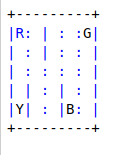

### Actions
There are 6 discrete deterministic actions:
  - 0: move south
  - 1: move north
  - 2: move east
  - 3: move west
  - 4: pickup passenger
  - 5: drop off passenger

### Observations
There are 500 discrete states since there are 25 taxi positions, 5 possible
locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Note that there are 400 states that can actually be reached during an
episode. The missing states correspond to situations in which the passenger
is at the same location as their destination, as this typically signals the
end of an episode. Four additional states can be observed right after a
successful episodes, when both the passenger and the taxi are at the destination.

This gives a total of 404 reachable discrete states.
Passenger locations:
  - 0: R(ed)
  - 1: G(reen)
  - 2: Y(ellow)
  - 3: B(lue)
  - 4: in taxi

Destinations:
  - 0: R(ed)
  - 1: G(reen)
  - 2: Y(ellow)
  - 3: B(lue)

Rewards
  - -1 per step unless other reward is triggered.
  - +20 delivering passenger.
  - -10  executing "pickup" and "drop-off" actions illegally.
  
Rendering
  - blue: passenger
  - magenta: destination
  - yellow: empty taxi
  - green: full taxi
  - other letters (R, G, Y and B): locations for passengers and destinations
state space is represented by:
  -(taxi_row, taxi_col, passenger_location, destination)

In [ ]:
# Importing libraries
import numpy as np
import gym
import random

### 1. Initializing the environment

Here we want taxi-v3. OpenAI Gym is a library composed of environments that we can use to train our agents. 

You can explore more about environments at: https://gym.openai.com/envs/#classic_control

In [ ]:
# Creating an environment
env = gym.make("Taxi-v3")

In [ ]:
# Rendering
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Let us now make a Q-table but to know the size of Q-table we first need to know the number of states and actions our environment has. 

To know this we can use the *`env.action_space.n`* and *`env.observation_space.n`*

###2. Number of states and actions

In [ ]:
action_size = env.action_space.n
print("Action-Size: ", action_size)

state_size = env.observation_space.n
print("State-Size: ", state_size)

Action-Size:  6
State-Size:  500


###3. Defining a Q-table

In [ ]:
# Define a q table
q_table = np.zeros((state_size, action_size))

In [ ]:
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])



In Deep Q-Learning, the input to the neural network are possible states of the environment and the output of the neural network is the action to be taken. 

The input_length for a discrete environment in OpenAi's gym (e.g Taxi, Frozen Lake) is 1 because the output from env.step(env.action_space.sample())[0] (e.g. the state it will be in), is a single number.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Embedding, Reshape
from tensorflow.keras import optimizers

In [ ]:
env.reset()
env.step(env.action_space.sample())[0]

348


In the Embedding layer, the input_dimensions refers to the number of states and output_dimensions refers to the vector space we are squishing it to. This means that we have 500 possible states and we want it to be represented by 6 values.

If you do not want to add any dense layers (meaning that you only want a single layer neural network, which is the embedding layer), you will have to set the output_dimensions of the Embedding layer to be the same as the action space of the environment. This means that output_dimensions must be 6 when you are using the Taxi environment because there can only be 6 actions, which are go up, go down, go left, go right, pickup passenger and drop passenger.


###4. Modelling

In [ ]:
!pip install keras-rl2

     |████████████████████████████████| 52 kB 689 kB/s 
     |████████████████████████████████| 462 kB 55.3 MB/s 


### 5. Perform Training 

In [ ]:
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
import tensorflow as tf

# Define an optimizer
Adam = tf.keras.optimizers.Adam

# Specify memory
memory = SequentialMemory(limit=50000, window_length=1)

# Specify the policy to be used
policy = EpsGreedyQPolicy()


If you want to add Dense layers after the Embedding layer, you can choose your own output_dimensions for your Embedding layer (it does not have to follow the action space size), but the final Dense layer must have the same output size as your action space size.

In the reshape layer, we take the output from the previous layer and reshape it to a rank 1 tensor (a one-dimensional array). In this notebook, (6,) means a one dimensional array with 6 values. For example, [1, 2, 3, 4, 5, 6] 

In [ ]:
# Modelling
model = Sequential()
model.add(Embedding(500, 10, input_length=1))
model.add(Reshape((10,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(action_size, activation='linear'))

# Model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             5000      
                                                                 
 reshape (Reshape)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 50)                550       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 6)                 306       
                                                                 
Total params: 10,956
Trainable params: 10,956
Non-traina

In [ ]:
# Get the dqn agent
dqn = DQNAgent(model=model, nb_actions=action_size, memory=memory, nb_steps_warmup=500, target_model_update=1e-2, policy=policy)

# Model compile
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Model fitting
dqn.fit(env, nb_steps=1000000, visualize=False, verbose=1, nb_max_episode_steps=99, log_interval=100000)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 1000000 steps ...
Interval 1 (0 steps performed)
    47/100000 [..............................] - ETA: 2:07 - reward: -1.1915   

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


100000/100000 [==============================] - 897s 9ms/step - reward: -1.2743
1091 episodes - episode_reward: -116.780 [-909.000, 15.000] - loss: 4.059 - mae: 25.282 - mean_q: -25.685 - prob: 1.000

Interval 2 (100000 steps performed)
100000/100000 [==============================] - 929s 9ms/step - reward: -0.5764
3787 episodes - episode_reward: -15.222 [-518.000, 15.000] - loss: 1.658 - mae: 12.483 - mean_q: -2.641 - prob: 1.000

Interval 3 (200000 steps performed)
100000/100000 [==============================] - 950s 9ms/step - reward: 0.1516
6763 episodes - episode_reward: 2.240 [-108.000, 15.000] - loss: 0.006 - mae: 7.328 - mean_q: 12.609 - prob: 1.000

Interval 4 (300000 steps performed)
100000/100000 [==============================] - 946s 9ms/step - reward: 0.1500
6788 episodes - episode_reward: 2.211 [-72.000, 15.000] - loss: 0.002 - mae: 7.387 - mean_q: 12.738 - prob: 1.000

Interval 5 (400000 steps performed)
100000/100000 [==============================] - 948s 9ms/step 

### 6. Perform Testing

In [ ]:
# Testing
dqn.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=99)

Testing for 5 episodes ...
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 1: reward: 12.000, steps: 9
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East

### 7. Save weights

In [ ]:
#  Saving weights
dqn.save_weights('dqn_{}_weights.h5f'.format("Taxi-v3"), overwrite=True)